<a href="https://colab.research.google.com/github/arumshin-dev/python_conda_jupyter/blob/main/codeit/2_4_7_Autoencoder_CNN_%EA%B3%B5%EC%9C%A0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 1. 라이브러리 임포트 및 MNIST 데이터셋 로드
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)  # Train 데이터셋 로드
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=4) # Train 데이터셋 데이터 로더 생성

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)  # Test 데이터셋 로드
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=4) # Test 데이터셋 데이터 로더 생성

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.08MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.25MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.16MB/s]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
# 2. 오토인코더 모델 생성
## CNN  코드
class CNNAutoencoder(nn.Module):
    def __init__(self):
        super(CNNAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, kernel_size=2, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded # Return both decoded image and the encoded feature map


Epoch [1/3], Loss: 0.8878
Epoch [2/3], Loss: 0.8438
Epoch [3/3], Loss: 0.8416


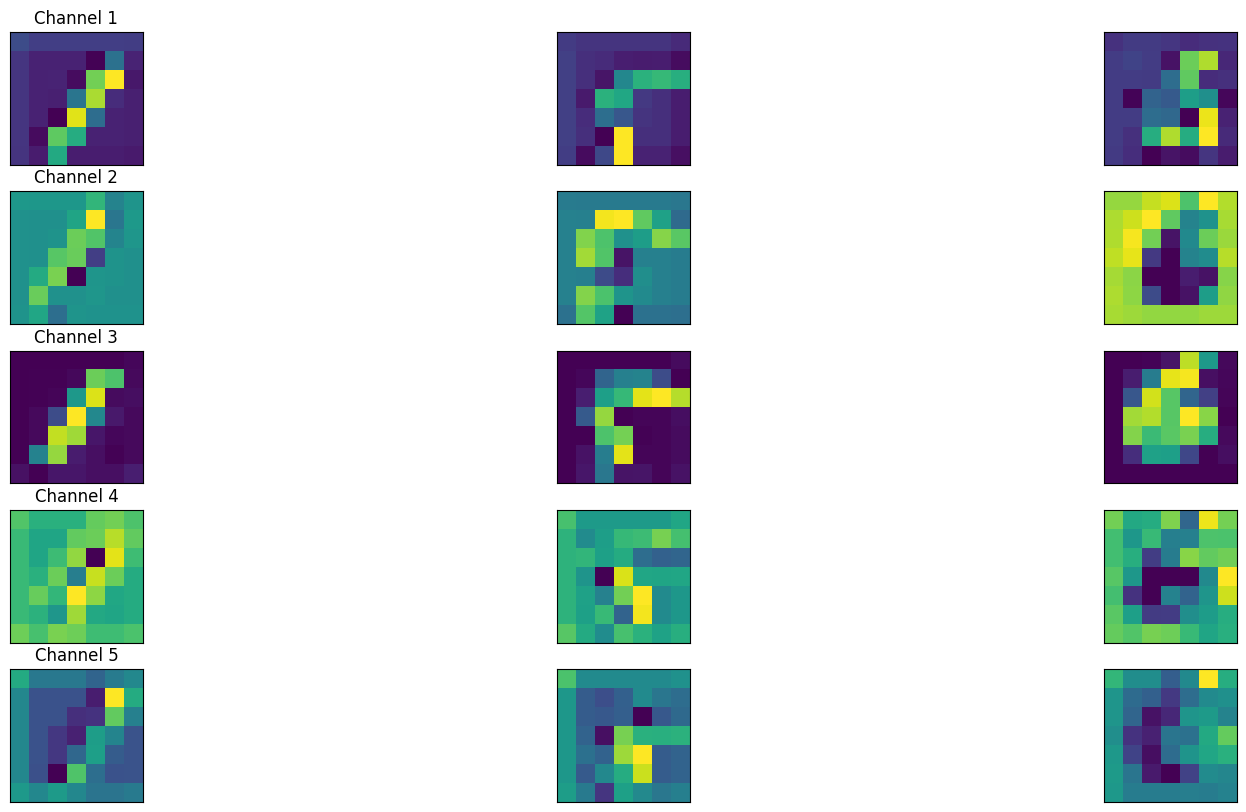

In [ ]:
# 모델 학습
model = CNNAutoencoder()
criterion = nn.MSELoss() # Mean Squared Error loss for autoencoders
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 3
num_channels_to_show = 5

plt.figure(figsize=(20, 10))

for epoch in range(num_epochs):
    model.train() # Set the model to training mode
    running_loss = 0.0
    for data in trainloader:
        inputs, _ = data # Autoencoder input is the image itself, ignore the label
        optimizer.zero_grad() # Zero the parameter gradients

        outputs, encoded_feat = model(inputs) # Forward pass

        loss = criterion(outputs, inputs) # Calculate the loss

        loss.backward() # Backward pass
        optimizer.step() # Optimize

        running_loss += loss.item()

    for c in range(num_channels_to_show):
      ax = plt.subplot(num_channels_to_show, num_epochs, epoch + c * num_epochs+1) # Adjust subplot position for multiple channels
      encoded_img_channel = encoded_feat[epoch, c, :, :].detach().cpu().numpy()
      plt.imshow(encoded_img_channel, cmap='viridis') # Use a different colormap for feature maps
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      if epoch == 0 and c >=0:
            ax.set_title(f"Channel {c+1}")

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(trainloader):.4f}')
    if epoch == num_epochs:
      print('Finished Training')
      # You can optionally save the trained model
      # torch.save(model.state_dict(), 'cnn_autoencoder.pth')

plt.show()


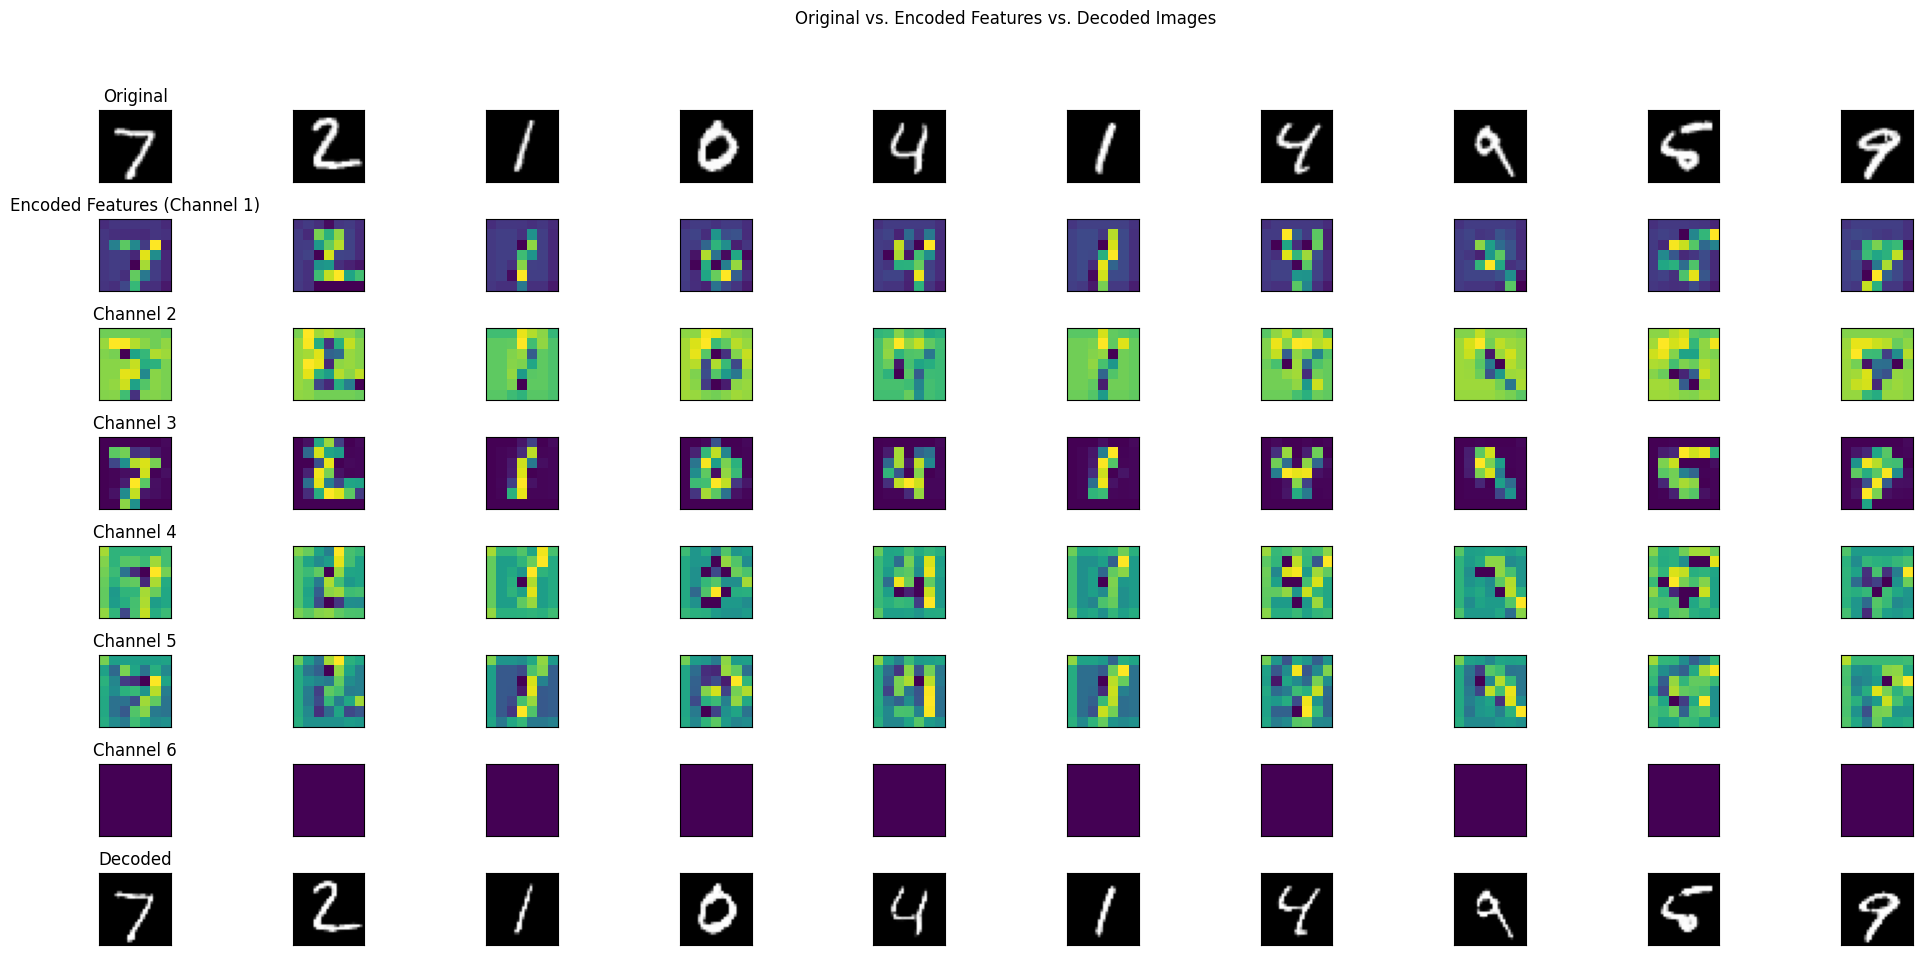


Shapes of Intermediate Tensors:
Input Image Batch Shape: torch.Size([128, 1, 28, 28])
Encoded Feature Batch Shape: torch.Size([128, 32, 7, 7])
Decoded Image Batch Shape: torch.Size([128, 1, 28, 28])


In [ ]:
# Evaluation and Intermediate Result Visualization

model.eval() # Set the model to evaluation mode
with torch.no_grad(): # No need to calculate gradients
    # Get a batch of test data
    dataiter = iter(testloader)
    images, labels = next(dataiter)

    # Forward pass through the autoencoder
    decoded_images, encoded_features = model(images)

    # Compare original images, encoded representations, and decoded images
    n = 10  # Number of images to display
    num_channels_to_show = 6 # You can adjust this

    plt.figure(figsize=(20, 10))
    for i in range(n):
        # Original Images
        ax = plt.subplot(num_channels_to_show+2, n, i + 1)
        # Unnormalize the image for display (reverse the normalization done during preprocessing)
        img = images[i].cpu().numpy() * 0.5 + 0.5
        plt.imshow(np.transpose(img.squeeze(), (0, 1)), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == 0:
            ax.set_title("Original")

        # Intermediate Encoded Feature Maps (Example of visualizing the output of the last encoder layer)
        # Select a few channels from the encoded features to visualize

        for c in range(num_channels_to_show):
            ax = plt.subplot(num_channels_to_show+2, n, n + i + c * n+1) # Adjust subplot position for multiple channels
            encoded_img_channel = encoded_features[i, c, :, :].cpu().numpy()
            plt.imshow(encoded_img_channel, cmap='viridis') # Use a different colormap for feature maps
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            if i == 0 and c == 0:
                 ax.set_title("Encoded Features (Channel 1)") # Label for the first channel
            elif i == 0 and c > 0:
                 ax.set_title(f"Channel {c+1}")


        # Decoded Images
        ax = plt.subplot(num_channels_to_show+2, n, (num_channels_to_show+1) * n + i + 1)
        # The decoder outputs values between 0 and 1 due to the Sigmoid activation
        decoded_img = decoded_images[i].cpu().numpy().squeeze()
        plt.imshow(decoded_img, cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == 0:
            ax.set_title("Decoded")

    plt.suptitle("Original vs. Encoded Features vs. Decoded Images")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()


    # Example of printing shapes of intermediate tensors (for debugging/understanding)
    print("\nShapes of Intermediate Tensors:")
    print(f"Input Image Batch Shape: {images.shape}") # Should be [batch_size, 1, 28, 28]
    print(f"Encoded Feature Batch Shape: {encoded_features.shape}") # Should be [batch_size, 32, 7, 7]
    print(f"Decoded Image Batch Shape: {decoded_images.shape}") # Should be [batch_size, 1, 28, 28]



In [ ]:
print(model)

CNNAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
    (3): Sigmoid()
  )
)


# Latent Vactor에 noise 추가

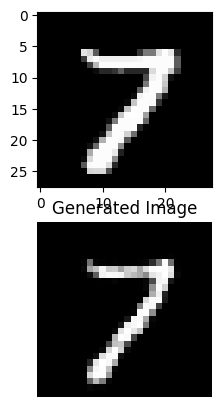

In [ ]:
import matplotlib.pyplot as plt
# Function to generate a new image from a random latent vector
def generate_image(model):
    smple_num = 34
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        # Create a random latent vector (matching the shape of the encoded features)
        # The shape of the encoded features is [batch_size, 32, 7, 7] based on the model definition.
        # For a single generated image, the batch size is 1.
        # random_latent_vector = encoded_features[smple_num].unsqueeze(0) + torch.randn(1, 32, 7, 7)
        random_latent_vector = encoded_features[smple_num].unsqueeze(0) * 0.7 +0.9

        # Pass the random latent vector through the decoder part of the model
        # We need to access the decoder directly.
        generated_image = model.decoder(random_latent_vector)

        # Unnormalize and convert to numpy for plotting
        # Since the decoder output has Sigmoid, it's already in [0, 1].
        generated_img_np = generated_image.squeeze().cpu().numpy()

        plt.figure(figsize=(5, 5))
        plt.subplot(2,1,1)
        plt.imshow(images[smple_num].squeeze(), cmap='gray')
        plt.subplot(2,1,2)
        plt.imshow(generated_img_np, cmap='gray')
        plt.title("Generated Image")
        plt.axis('off')
        plt.show()

# Generate a new image using the trained model
generate_image(model)
